# Comparación Equitativa de Agentes en RPS con Hiperparámetros Variados

Este cuaderno lleva a cabo una comparación completa entre distintos tipos de agentes en el juego Piedra-Papel-Tijera (RPS), garantizando una evaluación equitativa mediante:

1. **Entrenamiento uniforme**: todos los agentes entrenan con la misma cantidad de episodios.
2. **Variedad de configuraciones**: cada tipo de agente se prueba con diferentes hiperparámetros.
3. **Evaluación exhaustiva**: cada agente se enfrenta a todos los demás.
4. **Análisis detallado**: visualizamos los resultados para identificar qué algoritmos y configuraciones funcionan mejor.

## Hiperparámetros a evaluar para cada tipo de agente

### Fictitious Play (FP)
- **FP_default**: configuración estándar sin sesgos iniciales.
- **FP_biased**: configuración con sesgo inicial hacia ciertas acciones.

### Regret Matching (RM)
- **RM_default**: política inicial uniforme.
- **RM_biased**: política inicial sesgada hacia Piedra.

### Q-Learning Independiente (IQL)
- **IQL_default**: α=0.1, ε=0.1 (exploración equilibrada).
- **IQL_explore**: α=0.2, ε=0.3 (mayor exploración).
- **IQL_exploit**: α=0.05, ε=0.05 (mayor explotación).

### Joint-Action Learning con Modelado de Agente (JAL-AM)
- **JALAM_default**: α=0.1, ε=0.1 (configuración balanceada).
- **JALAM_explore**: α=0.2, ε=0.3 (mayor exploración).
- **JALAM_exploit**: α=0.05, ε=0.05 (mayor explotación).

# Comparación de Agentes en RPS

Este cuaderno compara el desempeño de distintos agentes en el juego Piedra-Papel-Tijera (RPS), evaluando diferentes hiperparámetros para conseguir una comparación justa.
Los agentes son:
- Fictitious Play (FP)
- Regret Matching (RM)
- Q-Learning Independiente (IQL)
- Joint-Action Learning con Modelado de Agente (JAL-AM)
- Agente Aleatorio (como línea base)

Vamos a entrenar los agentes de manera justa con diferentes hiperparámetros y luego ejecutar una serie de enfrentamientos entre distintas parejas de agentes.

## 1. Importaciones y configuración del entorno

Importamos las librerías necesarias y preparamos el entorno para el juego.

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys

# Add project root to sys.path to allow importing custom modules
module_path = os.path.abspath(os.path.join('..', 'Simultaneous Games')) # Adjust if notebook is in a different subfolder
if module_path not in sys.path:
    sys.path.append(module_path)

from games.rps import RPS
from agents.fictitiousplay_t import FictitiousPlay
from agents.regretmatching_t import RegretMatching
from agents.iql_agent import IQLAgent, IQLAgentConfig
from agents.jal_am_agent import JointActionLearningAgentModellingAgent
from agents.random_agent import RandomAgent
from base.game import SimultaneousGame, AgentID, ActionDict

## 2. Carga del entorno de juego RPS

In [56]:
game = RPS()
print("RPS game loaded.")
print("Agents:", game.agents)
print("Action spaces:", game.action_spaces)

RPS game loaded.
Agents: ['agent_0', 'agent_1']
Action spaces: {'agent_0': Discrete(3), 'agent_1': Discrete(3)}


## 3. Funciones auxiliares para cargar agentes entrenados

Definimos funciones que recuperan el estado guardado de los agentes entrenados en archivos `.pkl`.

In [ ]:
def load_fp_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int):
    agent = FictitiousPlay(game=game_instance, agent=agent_id)
    counts_path = os.path.join('fp_trainings', game_name, f'agent_{agent_idx}_fp_counts.pkl')
    if os.path.exists(counts_path):
        with open(counts_path, 'rb') as f:
            loaded_counts = pickle.load(f)
            # FP agent's __init__ initializes self.count and self.learned_policy
            # We need to correctly re-assign the loaded counts and update the policy
            agent.count = loaded_counts
            for ag, ct_array in agent.count.items():
                sum_counts = np.sum(ct_array)
                if sum_counts == 0:
                    agent.learned_policy[ag] = np.ones(game_instance.action_spaces[ag].n) / game_instance.action_spaces[ag].n
                else:
                    agent.learned_policy[ag] = ct_array / sum_counts
        print(f"Loaded Fictitious Play agent {agent_id} for {game_name} from {counts_path}")
    else:
        print(f"Warning: No saved counts found for FP agent {agent_id} at {counts_path}. Using fresh agent.")
    return agent

def load_rm_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int):
    agent = RegretMatching(game=game_instance, agent=agent_id)
    policy_path = os.path.join('rm_trainings', game_name, f'agent_{agent_idx}_rm_policy.pkl')
    if os.path.exists(policy_path):
        with open(policy_path, 'rb') as f:
            # RM saves the learned_policy directly
            agent.learned_policy = pickle.load(f)
        print(f"Loaded Regret Matching agent {agent_id} for {game_name} from {policy_path}")
    else:
        print(f"Warning: No saved policy found for RM agent {agent_id} at {policy_path}. Using fresh agent.")
    return agent

def load_iql_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int, config: IQLAgentConfig = None):
    if config is None:
        config = IQLAgentConfig(epsilon=0.0) # Set epsilon to 0 for evaluation (greedy policy)
    agent = IQLAgent(game=game_instance, agent=agent_id, config=config)
    q_table_path = os.path.join('iql_trainings', game_name, f'agent_{agent_idx}_q_table.pkl')
    if os.path.exists(q_table_path):
        with open(q_table_path, 'rb') as f:
            agent.Q = pickle.load(f)
        print(f"Loaded IQL agent {agent_id} for {game_name} from {q_table_path}")
    else:
        print(f"Warning: No saved Q-table found for IQL agent {agent_id} at {q_table_path}. Using fresh agent.")
    agent.epsilon = 0 # Ensure greedy policy for evaluation
    return agent

def load_jalam_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int):
    # JALAM training notebook saves the whole agent object.
    # However, the file structure shows `training_rewards_jalam.pkl` but not agent objects.
    # Let's assume for now it saves Q-tables or similar, like IQL.
    # If it saves the whole agent, the loading mechanism would be simpler: pickle.load(f)
    # The JALAMAgent_Training.ipynb needs to be checked for how it saves.
    # For now, let's assume a similar structure to IQL for Q-table saving.
    # Path: jalam_trainings/RPS/agent_0_jalam_q_table.pkl (hypothetical)

    # Based on JALAMAgent_Training.ipynb, it seems to save the Q table and counts.
    # Let's assume a path like: jalam_trainings/RPS/agent_0_jalam_data.pkl which is a dict
    # {'Q': Q_table, 'opp_count': opp_count, 'joint_count': joint_count}

    agent = JointActionLearningAgentModellingAgent(game=game_instance, agent=agent_id, epsilon=0.0) # Epsilon = 0 for eval
    data_path = os.path.join('jalam_trainings', game_name, f'agent_{agent_idx}_jalam_model.pkl') # Ruta según JALAMAgent_Training.ipynb

    if os.path.exists(data_path):
        with open(data_path, 'rb') as f:
            saved_data = pickle.load(f)
            # Según JALAMAgent_Training.ipynb, guarda como 'Q_table' y 'model_counts'
            if 'Q_table' in saved_data and hasattr(agent, 'Q'):
                agent.Q = saved_data['Q_table']
            if 'model_counts' in saved_data and hasattr(agent, 'model_counts'):
                agent.model_counts = saved_data['model_counts']
            # Para compatibilidad con diferentes versiones
            if 'Q' in saved_data and hasattr(agent, 'Q'):
                agent.Q = saved_data['Q']
            if 'opp_count' in saved_data and hasattr(agent, 'opp_count'):
                agent.opp_count = saved_data['opp_count']
            if 'joint_count' in saved_data and hasattr(agent, 'joint_count'):
                agent.joint_count = saved_data['joint_count']
        print(f"Loaded JAL-AM agent {agent_id} for {game_name} from {data_path}")
    else:
        print(f"Warning: No saved model found for JAL-AM agent {agent_id} at {data_path}. Using fresh agent.")
    agent.epsilon = 0 # Ensure greedy policy
    return agent


## 4. Cargar agentes entrenados para RPS

Instanciar agentes. Para los agentes entrenados, cargamos su estado guardado.
El juego es RPS y los agentes son “agent_0” y “agent_1”.

In [58]:
GAME_NAME = "RPS"
agent_ids = game.agents # ["agent_0", "agent_1"]

# Define hyperparameter configurations for each agent type
# These configurations will be used to create agent instances with different parameters

# Fictitious Play Configurations
fp_configs = [
    {"name": "FP_default", "params": {"initial": None, "seed": 42}},
    {"name": "FP_biased", "params": {"initial": {agent_ids[0]: [2, 1, 1], agent_ids[1]: [1, 2, 1]}, "seed": 42}}
]

# Regret Matching Configurations
rm_configs = [
    {"name": "RM_default", "params": {"initial": None, "seed": 42}},
    # Initial policy biased towards Rock (higher probability for action 0)
    {"name": "RM_biased", "params": {"initial": np.array([0.6, 0.2, 0.2]), "seed": 42}}
]

# IQL Configurations
iql_configs = [
    {"name": "IQL_default", "params": {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1, "min_epsilon": 0.01, "epsilon_decay": 0.995, "seed": 42}},
    {"name": "IQL_explore", "params": {"alpha": 0.2, "gamma": 0.99, "epsilon": 0.3, "min_epsilon": 0.05, "epsilon_decay": 0.99, "seed": 42}},
    {"name": "IQL_exploit", "params": {"alpha": 0.05, "gamma": 0.99, "epsilon": 0.05, "min_epsilon": 0.01, "epsilon_decay": 0.999, "seed": 42}}
]

# JAL-AM Configurations
jalam_configs = [
    {"name": "JALAM_default", "params": {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1, "min_epsilon": 0.01, "epsilon_decay": 0.995, "seed": 42}},
    {"name": "JALAM_explore", "params": {"alpha": 0.2, "gamma": 0.99, "epsilon": 0.3, "min_epsilon": 0.05, "epsilon_decay": 0.99, "seed": 42}},
    {"name": "JALAM_exploit", "params": {"alpha": 0.05, "gamma": 0.99, "epsilon": 0.05, "min_epsilon": 0.01, "epsilon_decay": 0.999, "seed": 42}}
]

# Function to create agent instances with specified configurations
def create_fp_agent(game_instance, agent_id, config):
    return FictitiousPlay(game=game_instance, agent=agent_id, **config["params"])

def create_rm_agent(game_instance, agent_id, config):
    return RegretMatching(game=game_instance, agent=agent_id, **config["params"])

def create_iql_agent(game_instance, agent_id, config):
    # Convert config dict to IQLAgentConfig object
    iql_config = IQLAgentConfig(**config["params"])
    return IQLAgent(game=game_instance, agent=agent_id, config=iql_config)

def create_jalam_agent(game_instance, agent_id, config):
    return JointActionLearningAgentModellingAgent(game=game_instance, agent=agent_id, **config["params"])

# Dictionary to store all agent instances we create
agents_pool = {}

# Create Random agent (baseline)
random_agent_0 = RandomAgent(game, agent_ids[0])
random_agent_1 = RandomAgent(game, agent_ids[1])
agents_pool["Random"] = random_agent_0

print("Creating agent instances with different hyperparameters...")

# Create FP agents
for config in fp_configs:
    agent = create_fp_agent(game, agent_ids[0], config)
    agents_pool[config["name"]] = agent
    print(f"Created {config['name']} agent")

# Create RM agents
for config in rm_configs:
    agent = create_rm_agent(game, agent_ids[0], config)
    agents_pool[config["name"]] = agent
    print(f"Created {config['name']} agent")

# Create IQL agents
for config in iql_configs:
    agent = create_iql_agent(game, agent_ids[0], config)
    agents_pool[config["name"]] = agent
    print(f"Created {config['name']} agent")

# Create JAL-AM agents
for config in jalam_configs:
    agent = create_jalam_agent(game, agent_ids[0], config)
    agents_pool[config["name"]] = agent
    print(f"Created {config['name']} agent")

print("\nAvailable agents for comparison:", list(agents_pool.keys()))

Creating agent instances with different hyperparameters...
Created FP_default agent
Created FP_biased agent
Created RM_default agent
Created RM_biased agent
Created IQL_default agent
Created IQL_explore agent
Created IQL_exploit agent
Created JALAM_default agent
Created JALAM_explore agent
Created JALAM_exploit agent

Available agents for comparison: ['Random', 'FP_default', 'FP_biased', 'RM_default', 'RM_biased', 'IQL_default', 'IQL_explore', 'IQL_exploit', 'JALAM_default', 'JALAM_explore', 'JALAM_exploit']


## 5. Función de simulación

Esta función ejecuta un enfrentamiento entre dos agentes durante una cantidad determinada de episodios.

In [59]:
def run_match(game_instance: SimultaneousGame, agent1, agent2, num_episodes: int):
    """
    Corre un enfrentamiento entre dos agentes:
    agent1 juega como game_instance.agents[0]
    agent2 juega como game_instance.agents[1]
    """
    agent1_id = game_instance.agents[0]
    agent2_id = game_instance.agents[1]
   
    total_rewards_agent1 = 0
    total_rewards_agent2 = 0
    
    history_rewards_agent1 = []
    history_rewards_agent2 = []
   
    for episode in range(num_episodes):
        game_instance.reset()
        
        # Reiniciar al agente si tiene método reset (por ej. IQL)
        if hasattr(agent1, 'reset'):
            agent1.reset()
        if hasattr(agent2, 'reset'):
            agent2.reset()

        # En RPS el juego termina en un paso
        # Para juegos más complejos habría un bucle hasta done
        
        action1 = agent1.action()
        action2 = agent2.action()
        
        acciones = {agent1_id: action1, agent2_id: action2}
        
        obs, rewards, terminations, truncations, infos = game_instance.step(acciones)
        
        total_rewards_agent1 += rewards[agent1_id]
        total_rewards_agent2 += rewards[agent2_id]
        history_rewards_agent1.append(rewards[agent1_id])
        history_rewards_agent2.append(rewards[agent2_id])
        
        # Llamar update para agentes que aprenden online
        if hasattr(agent1, 'update'):
            agent1.update()
        if hasattr(agent2, 'update'):
            agent2.update()
   
    avg_reward_agent1 = total_rewards_agent1 / num_episodes
    avg_reward_agent2 = total_rewards_agent2 / num_episodes
    
    return {
        "avg_reward_agent1": avg_reward_agent1,
        "avg_reward_agent2": avg_reward_agent2,
        "history_agent1": history_rewards_agent1,
        "history_agent2": history_rewards_agent2,
    }
   
print("Función de simulación definida.")

Función de simulación definida.


In [60]:
def run_match(game_instance: SimultaneousGame, agent1, agent2, num_episodes: int):
    """
    Corre un enfrentamiento entre dos agentes:
    agent1 juega como game_instance.agents[0]
    agent2 juega como game_instance.agents[1]
    """
    agent1_id = game_instance.agents[0]
    agent2_id = game_instance.agents[1]
   
    total_rewards_agent1 = 0
    total_rewards_agent2 = 0
    
    history_rewards_agent1 = []
    history_rewards_agent2 = []
    
    # Track actions for strategy analysis
    action_counts_agent1 = [0, 0, 0]  # Rock, Paper, Scissors count
    action_counts_agent2 = [0, 0, 0]  # Rock, Paper, Scissors count
   
    for episode in range(num_episodes):
        game_instance.reset()
        
        # Reiniciar al agente si tiene método reset (por ej. IQL)
        if hasattr(agent1, 'reset'):
            agent1.reset()
        if hasattr(agent2, 'reset'):
            agent2.reset()

        # En RPS el juego termina en un paso
        # Para juegos más complejos habría un bucle hasta done
        
        action1 = agent1.action()
        action2 = agent2.action()
        
        # Track action counts
        action_counts_agent1[action1] += 1
        action_counts_agent2[action2] += 1
        
        acciones = {agent1_id: action1, agent2_id: action2}
        
        obs, rewards, terminations, truncations, infos = game_instance.step(acciones)
        
        total_rewards_agent1 += rewards[agent1_id]
        total_rewards_agent2 += rewards[agent2_id]
        history_rewards_agent1.append(rewards[agent1_id])
        history_rewards_agent2.append(rewards[agent2_id])
        
        # Llamar update para agentes que aprenden online
        if hasattr(agent1, 'update'):
            agent1.update()
        if hasattr(agent2, 'update'):
            agent2.update()
   
    avg_reward_agent1 = total_rewards_agent1 / num_episodes
    avg_reward_agent2 = total_rewards_agent2 / num_episodes
    
    # Calculate action distributions
    action_dist_agent1 = np.array(action_counts_agent1) / num_episodes
    action_dist_agent2 = np.array(action_counts_agent2) / num_episodes
    
    return {
        "avg_reward_agent1": avg_reward_agent1,
        "avg_reward_agent2": avg_reward_agent2,
        "history_agent1": history_rewards_agent1,
        "history_agent2": history_rewards_agent2,
        "action_dist_agent1": action_dist_agent1,
        "action_dist_agent2": action_dist_agent2,
    }
   
print("Función de simulación mejorada definida con seguimiento de acciones.")

Función de simulación mejorada definida con seguimiento de acciones.


## 6. Definir parejas y ejecutar experimentos

Configuramos las parejas de agentes que se enfrentarán y ejecutamos los experimentos.

In [61]:
def get_agent_instance(agent_type_str, game_instance, agent_id_in_game, config=None):
    """
    Creates an agent instance with specific hyperparameters.
    
    Args:
        agent_type_str: Base agent type ('FP', 'RM', 'IQL', 'JALAM', 'Random')
        game_instance: The game environment
        agent_id_in_game: The agent's ID in the game
        config: Dictionary of hyperparameters for the agent
    """
    if agent_type_str == "Random":
        return RandomAgent(game_instance, agent_id_in_game)
    
    if agent_type_str == "FP":
        if config is None:
            config = {"initial": None, "seed": 42}
        return FictitiousPlay(game=game_instance, agent=agent_id_in_game, **config)
    
    elif agent_type_str == "RM":
        if config is None:
            config = {"initial": None, "seed": 42}
        return RegretMatching(game=game_instance, agent=agent_id_in_game, **config)
    
    elif agent_type_str == "IQL":
        if config is None:
            config = {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1, "min_epsilon": 0.01, "epsilon_decay": 0.995, "seed": 42}
        iql_config = IQLAgentConfig(**config)
        return IQLAgent(game=game_instance, agent=agent_id_in_game, config=iql_config)
    
    elif agent_type_str == "JALAM":
        if config is None:
            config = {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1, "min_epsilon": 0.01, "epsilon_decay": 0.995, "seed": 42}
        return JointActionLearningAgentModellingAgent(game=game_instance, agent=agent_id_in_game, **config)
    
    else:
        raise ValueError(f"Unknown agent type: {agent_type_str}")

# Create dictionary to map agent names in agents_pool to their type and configuration
agent_configs = {}
for name in agents_pool:
    if name == "Random":
        agent_configs[name] = {"type": "Random", "config": None}
    elif name.startswith("FP_"):
        config = next(config for config in fp_configs if config["name"] == name)["params"]
        agent_configs[name] = {"type": "FP", "config": config}
    elif name.startswith("RM_"):
        config = next(config for config in rm_configs if config["name"] == name)["params"]
        agent_configs[name] = {"type": "RM", "config": config}
    elif name.startswith("IQL_"):
        config = next(config for config in iql_configs if config["name"] == name)["params"]
        agent_configs[name] = {"type": "IQL", "config": config}
    elif name.startswith("JALAM_"):
        config = next(config for config in jalam_configs if config["name"] == name)["params"]
        agent_configs[name] = {"type": "JALAM", "config": config}

print("\nAgent configurations prepared for matching.")


Agent configurations prepared for matching.


In [62]:
# Define number of episodes for training and evaluation
TRAINING_EPISODES = 5000  # Episodes for training each agent
EVAL_EPISODES = 1000      # Episodes for evaluation of trained agents

# First step: Let's train all learning agents with self-play
print(f"\nTraining agents with self-play for {TRAINING_EPISODES} episodes each...")

def train_agent(agent_name, agent_type, config, num_episodes):
    """Train an agent using self-play for specified episodes"""
    training_game = RPS()
    
    # Create two instances of the same agent type with the same config
    agent1 = get_agent_instance(agent_type, training_game, training_game.agents[0], config)
    agent2 = get_agent_instance(agent_type, training_game, training_game.agents[1], config)
    
    # Run self-play training
    for _ in range(num_episodes):
        training_game.reset()
        
        # Reset agents if they have a reset method
        if hasattr(agent1, 'reset'):
            agent1.reset()
        if hasattr(agent2, 'reset'):
            agent2.reset()
            
        # Get actions from both agents
        action1 = agent1.action()
        action2 = agent2.action()
        
        # Step the environment
        actions = {training_game.agents[0]: action1, training_game.agents[1]: action2}
        _, rewards, _, _, _ = training_game.step(actions)
        
        # Update agents if they have an update method
        if hasattr(agent1, 'update'):
            agent1.update()
        if hasattr(agent2, 'update'):
            agent2.update()
    
    print(f"Completed training for {agent_name}")
    
    # Return the trained agent for player 0
    return agent1

# Train each agent and replace the ones in the agent pool with trained versions
trained_agents = {}
for name, info in agent_configs.items():
    if name != "Random":  # Skip training for random agent
        print(f"\nTraining {name}...")
        trained_agent = train_agent(name, info["type"], info["config"], TRAINING_EPISODES)
        trained_agents[name] = trained_agent

# Replace untrained agents in the agents_pool with trained versions
for name, agent in trained_agents.items():
    agents_pool[name] = agent

print("\nTraining complete! Now setting up evaluation matches...")

# Generate all pairs of agents for evaluation
evaluation_pairs = []
for agent1_name in agents_pool:
    for agent2_name in agents_pool:
        # Skip identical agent pairs if desired, or include them for self-play evaluation
        if agent1_name != agent2_name:  # Comment out to include self-play
            evaluation_pairs.append((agent1_name, agent2_name))

print(f"Will run {len(evaluation_pairs)} evaluation matches with {EVAL_EPISODES} episodes each")

# Run all evaluation matches
results = {}

for agent1_name, agent2_name in evaluation_pairs:
    match_key = f"{agent1_name}_vs_{agent2_name}"
    print(f"\nEvaluating match: {match_key}")
    
    # Create a fresh game instance for this match
    eval_game = RPS()
    
    # Get the agent configurations
    agent1_info = agent_configs[agent1_name]
    agent2_info = agent_configs[agent2_name]
    
    # Create fresh instances for this match to avoid carryover
    agent1 = get_agent_instance(agent1_info["type"], eval_game, eval_game.agents[0], agent1_info["config"])
    agent2 = get_agent_instance(agent2_info["type"], eval_game, eval_game.agents[1], agent2_info["config"])
    
    # If the agents are trained, we should copy over learned policies/Q-tables
    if agent1_name in trained_agents:
        # Copy learned data based on agent type
        if hasattr(trained_agents[agent1_name], "Q") and hasattr(agent1, "Q"):
            agent1.Q = trained_agents[agent1_name].Q.copy()
        if hasattr(trained_agents[agent1_name], "learned_policy") and hasattr(agent1, "learned_policy"):
            agent1.learned_policy = trained_agents[agent1_name].learned_policy.copy()
        if hasattr(trained_agents[agent1_name], "count") and hasattr(agent1, "count"):
            agent1.count = trained_agents[agent1_name].count.copy()
        if hasattr(trained_agents[agent1_name], "cum_regrets") and hasattr(agent1, "cum_regrets"):
            agent1.cum_regrets = trained_agents[agent1_name].cum_regrets.copy()
    
    if agent2_name in trained_agents:
        # Copy learned data based on agent type
        if hasattr(trained_agents[agent2_name], "Q") and hasattr(agent2, "Q"):
            agent2.Q = trained_agents[agent2_name].Q.copy()
        if hasattr(trained_agents[agent2_name], "learned_policy") and hasattr(agent2, "learned_policy"):
            agent2.learned_policy = trained_agents[agent2_name].learned_policy.copy()
        if hasattr(trained_agents[agent2_name], "count") and hasattr(agent2, "count"):
            agent2.count = trained_agents[agent2_name].count.copy()
        if hasattr(trained_agents[agent2_name], "cum_regrets") and hasattr(agent2, "cum_regrets"):
            agent2.cum_regrets = trained_agents[agent2_name].cum_regrets.copy()
    
    # For evaluation, ensure no exploration
    if hasattr(agent1, "epsilon"):
        agent1.epsilon = 0
    if hasattr(agent2, "epsilon"):
        agent2.epsilon = 0
    
    # Run the match
    match_results = run_match(eval_game, agent1, agent2, EVAL_EPISODES)
    results[match_key] = match_results
    
    print(f"  Results: {agent1_name} avg reward: {match_results['avg_reward_agent1']:.3f}, "
          f"{agent2_name} avg reward: {match_results['avg_reward_agent2']:.3f}")

print("\nAll evaluation matches completed.")


Training agents with self-play for 5000 episodes each...

Training FP_default...
Completed training for FP_default

Training FP_biased...
Completed training for FP_biased

Training RM_default...
Completed training for RM_default

Training RM_biased...
Completed training for RM_biased

Training IQL_default...
Completed training for IQL_default

Training IQL_explore...
Completed training for IQL_explore

Training IQL_exploit...
Completed training for IQL_exploit

Training JALAM_default...
Completed training for JALAM_default

Training JALAM_explore...
Completed training for JALAM_explore

Training JALAM_exploit...
Completed training for JALAM_exploit

Training complete! Now setting up evaluation matches...
Will run 110 evaluation matches with 1000 episodes each

Evaluating match: Random_vs_FP_default
  Results: Random avg reward: 0.021, FP_default avg reward: -0.021

Evaluating match: Random_vs_FP_biased
Completed training for JALAM_default

Training JALAM_explore...
Completed training 

## 7. Analizar y visualizar resultados detallados

En esta sección analizamos los resultados de todas las configuraciones de agentes y sus enfrentamientos.

## 7. Analizar y visualizar resultados detallados

A continuación analizaremos los resultados de todas las configuraciones de agentes y sus enfrentamientos.


Seaborn library not found. Using matplotlib for basic visualizations.
To install seaborn run: pip install seaborn

=== Summary of Average Rewards ===

Random_vs_FP_default: Random got 0.021, FP_default got -0.021
Random_vs_FP_biased: Random got -0.005, FP_biased got 0.005
Random_vs_RM_default: Random got 0.018, RM_default got -0.018
Random_vs_RM_biased: Random got -0.003, RM_biased got 0.003
Random_vs_IQL_default: Random got -0.001, IQL_default got 0.001
Random_vs_IQL_explore: Random got -0.020, IQL_explore got 0.020
Random_vs_IQL_exploit: Random got 0.001, IQL_exploit got -0.001
Random_vs_JALAM_default: Random got -0.002, JALAM_default got 0.002
Random_vs_JALAM_explore: Random got -0.002, JALAM_explore got 0.002
Random_vs_JALAM_exploit: Random got -0.002, JALAM_exploit got 0.002
FP_default_vs_Random: FP_default got -0.027, Random got 0.027
FP_default_vs_FP_biased: FP_default got -0.010, FP_biased got 0.010
FP_default_vs_RM_default: FP_default got 0.000, RM_default got 0.000
FP_default

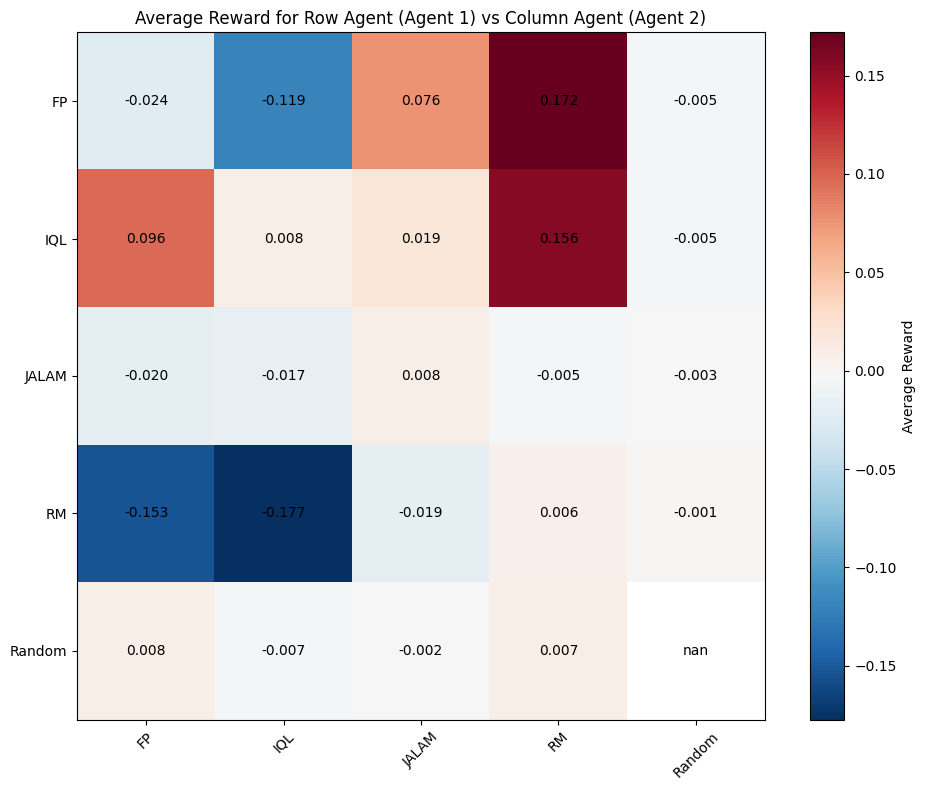

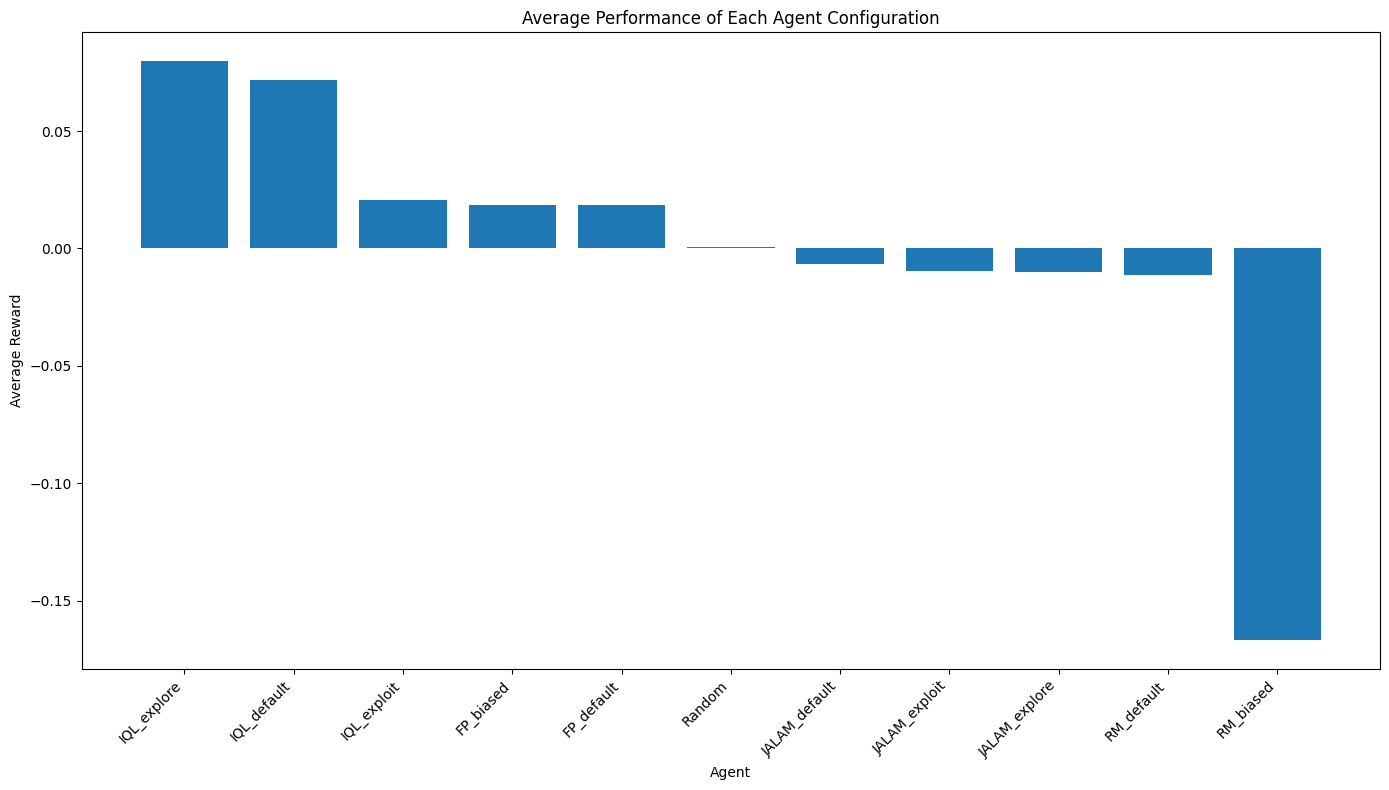

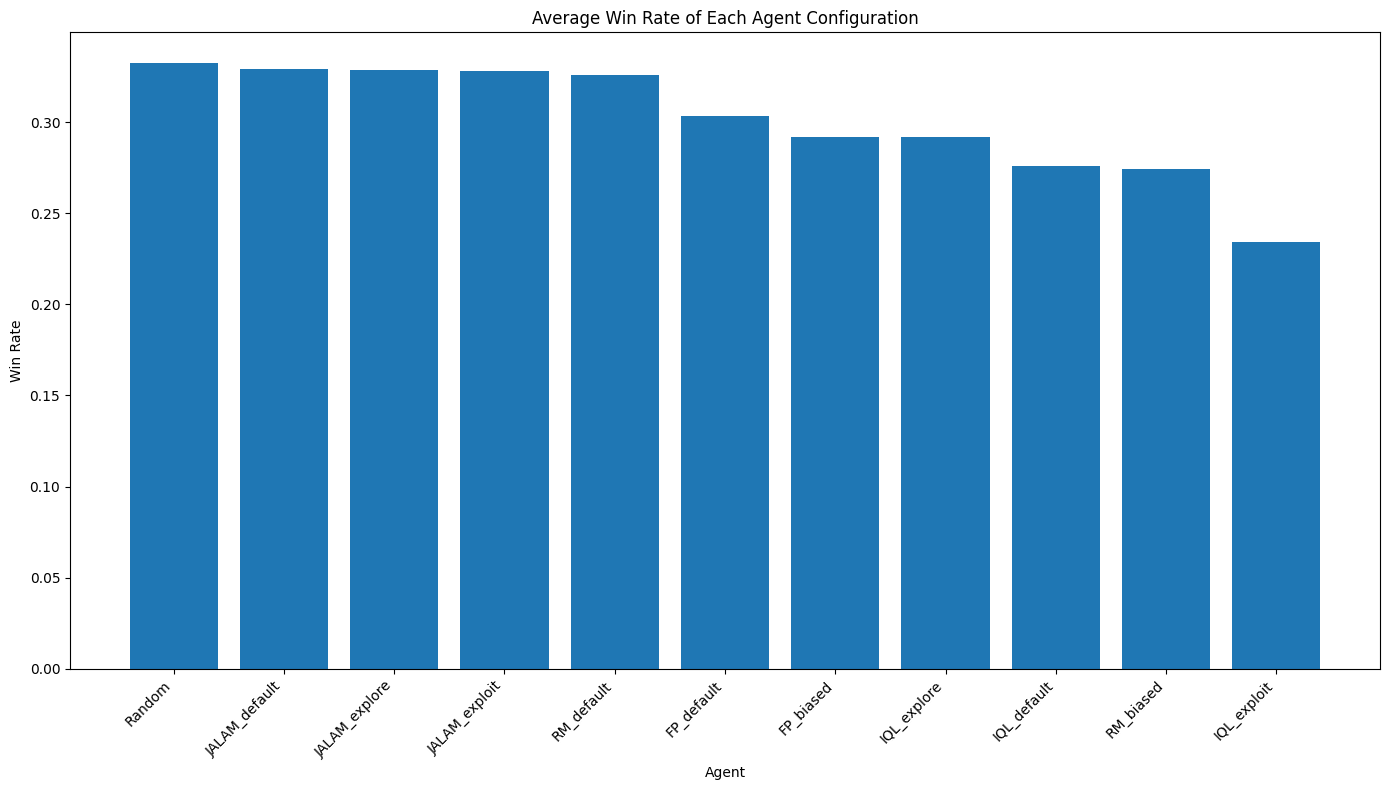


Analysis complete. The charts show how different agent configurations perform against each other.


In [63]:
import pandas as pd

# Try to import seaborn for advanced visualizations, fallback to matplotlib if not available
try:
    import seaborn as sns
    has_seaborn = True
except ImportError:
    has_seaborn = False
    print("Seaborn library not found. Using matplotlib for basic visualizations.")
    print("To install seaborn run: pip install seaborn")

# Create DataFrame for easier analysis
results_data = []
for match_key, res in results.items():
    agent1_name, agent2_name = match_key.split('_vs_')
    
    # Calculate win/loss/tie statistics
    hist1 = res['history_agent1']
    hist2 = res['history_agent2']
    wins1 = sum(1 for r in hist1 if r > 0)
    wins2 = sum(1 for r in hist2 if r > 0)
    ties = sum(1 for r in hist1 if r == 0)
    total = len(hist1)
    
    # Create data row
    results_data.append({
        'match': match_key,
        'agent1': agent1_name,
        'agent2': agent2_name,
        'agent1_avg_reward': res['avg_reward_agent1'],
        'agent2_avg_reward': res['avg_reward_agent2'],
        'agent1_win_rate': wins1 / total,
        'agent2_win_rate': wins2 / total,
        'tie_rate': ties / total,
        'agent1_type': agent1_name.split('_')[0] if '_' in agent1_name else agent1_name,
        'agent2_type': agent2_name.split('_')[0] if '_' in agent2_name else agent2_name,
    })

# Convert to DataFrame
df_results = pd.DataFrame(results_data)

# 1. Summary of average rewards
print("\n=== Summary of Average Rewards ===\n")
for _, row in df_results.iterrows():
    print(f"{row['match']}: {row['agent1']} got {row['agent1_avg_reward']:.3f}, {row['agent2']} got {row['agent2_avg_reward']:.3f}")

# 2. Win/Loss/Tie rates
print("\n=== Win/Tie/Loss Analysis ===\n")
for _, row in df_results.iterrows():
    print(f"Match {row['match']}:")
    print(f"  {row['agent1']} win rate: {row['agent1_win_rate']:.1%}")
    print(f"  {row['agent2']} win rate: {row['agent2_win_rate']:.1%}")
    print(f"  Tie rate: {row['tie_rate']:.1%}")

# 3. Visualization: Heat map of agent performance
print("\n=== Creating performance visualizations... ===\n")

# First, create a pivot table for average rewards
agent_types = list(set([row['agent1_type'] for _, row in df_results.iterrows()]))
pivot_data = []

for agent1_type in agent_types:
    for agent2_type in agent_types:
        avg_rewards = []
        # Find all matches with this type pairing
        for _, row in df_results.iterrows():
            if row['agent1_type'] == agent1_type and row['agent2_type'] == agent2_type:
                avg_rewards.append(row['agent1_avg_reward'])
        # Only add if we found matches
        if avg_rewards:
            pivot_data.append({
                'agent1_type': agent1_type,
                'agent2_type': agent2_type,
                'avg_reward': np.mean(avg_rewards)
            })

df_pivot = pd.DataFrame(pivot_data)

# Create heatmap for type-vs-type performance
if len(df_pivot) > 0:
    pivot_table = df_pivot.pivot(index='agent1_type', columns='agent2_type', values='avg_reward')
    plt.figure(figsize=(10, 8))
    if has_seaborn:
        sns.heatmap(pivot_table, annot=True, cmap='RdBu_r', center=0, fmt='.3f')
    else:
        # Basic heatmap with matplotlib if seaborn is not available
        plt.imshow(pivot_table.values, cmap='RdBu_r')
        plt.colorbar(label='Average Reward')
        # Add annotations
        for i in range(pivot_table.shape[0]):
            for j in range(pivot_table.shape[1]):
                plt.text(j, i, f'{pivot_table.values[i, j]:.3f}', 
                        ha='center', va='center', color='black')
        plt.xticks(range(len(pivot_table.columns)), pivot_table.columns, rotation=45)
        plt.yticks(range(len(pivot_table.index)), pivot_table.index)
    
    plt.title('Average Reward for Row Agent (Agent 1) vs Column Agent (Agent 2)')
    plt.tight_layout()
    plt.show()
else:
    print("No data available for heatmap visualization.")

# 4. Bar chart comparison
plt.figure(figsize=(14, 8))

# Sort by agent1 performance
df_summary = df_results.groupby('agent1')['agent1_avg_reward'].mean().reset_index()
df_summary = df_summary.sort_values('agent1_avg_reward', ascending=False)

# Create bar chart
if has_seaborn:
    sns.barplot(x='agent1', y='agent1_avg_reward', data=df_summary)
else:
    # Matplotlib fallback
    plt.bar(df_summary['agent1'], df_summary['agent1_avg_reward'])

plt.title('Average Performance of Each Agent Configuration')
plt.xlabel('Agent')
plt.ylabel('Average Reward')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 5. Win rate analysis
win_rates = df_results.groupby('agent1')['agent1_win_rate'].mean().reset_index()
win_rates = win_rates.sort_values('agent1_win_rate', ascending=False)

plt.figure(figsize=(14, 8))
if has_seaborn:
    sns.barplot(x='agent1', y='agent1_win_rate', data=win_rates)
else:
    plt.bar(win_rates['agent1'], win_rates['agent1_win_rate'])

plt.title('Average Win Rate of Each Agent Configuration')
plt.xlabel('Agent')
plt.ylabel('Win Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nAnalysis complete. The charts show how different agent configurations perform against each other.")


=== Strategy Analysis for Selected Matchups ===


Analyzing strategy for match: FP_default_vs_Random
FP_default action distribution: Rock=1.00, Paper=0.00, Scissors=0.00
Random action distribution: Rock=0.33, Paper=0.35, Scissors=0.32


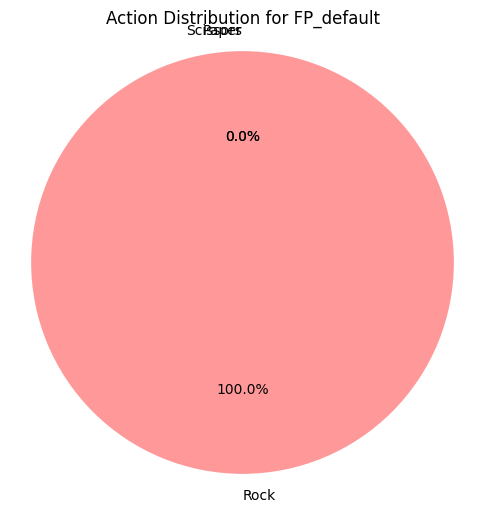

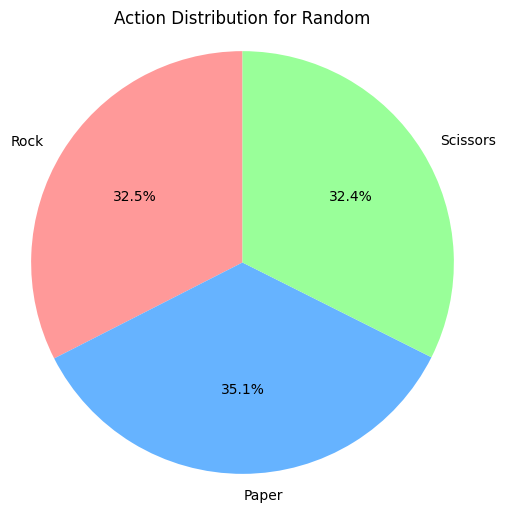


Analyzing strategy for match: RM_default_vs_Random
RM_default action distribution: Rock=0.34, Paper=0.32, Scissors=0.33
Random action distribution: Rock=0.33, Paper=0.33, Scissors=0.35


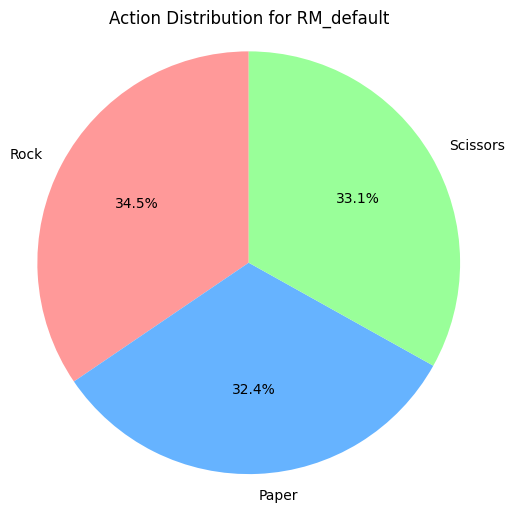

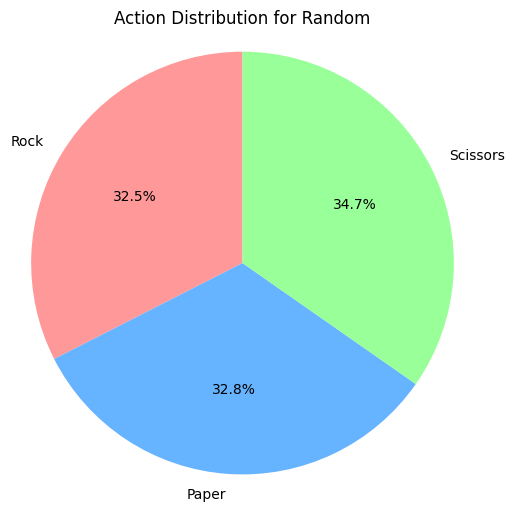


Analyzing strategy for match: IQL_default_vs_Random
IQL_default action distribution: Rock=0.00, Paper=0.63, Scissors=0.36
Random action distribution: Rock=0.34, Paper=0.34, Scissors=0.32


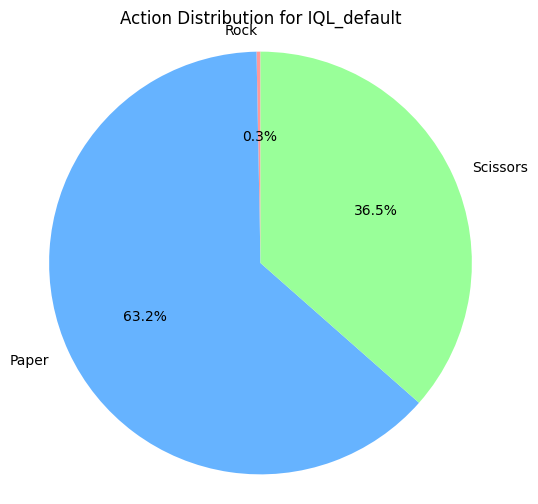

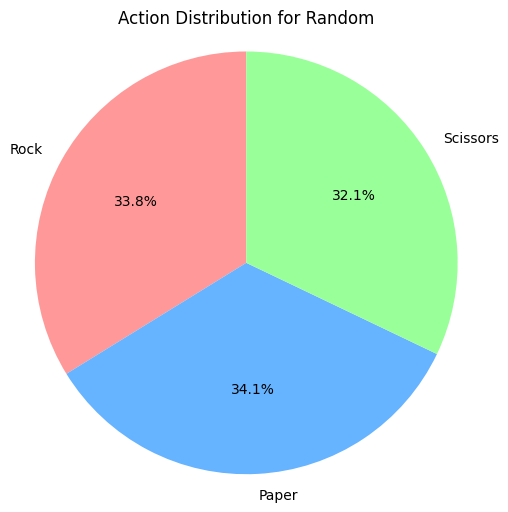


Analyzing strategy for match: JALAM_default_vs_Random
JALAM_default action distribution: Rock=0.32, Paper=0.35, Scissors=0.33
Random action distribution: Rock=0.33, Paper=0.34, Scissors=0.33


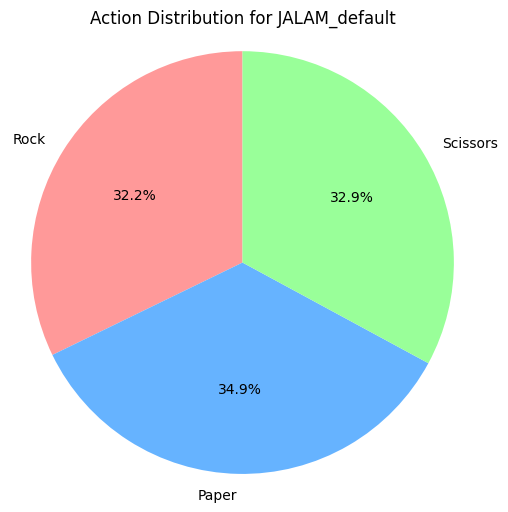

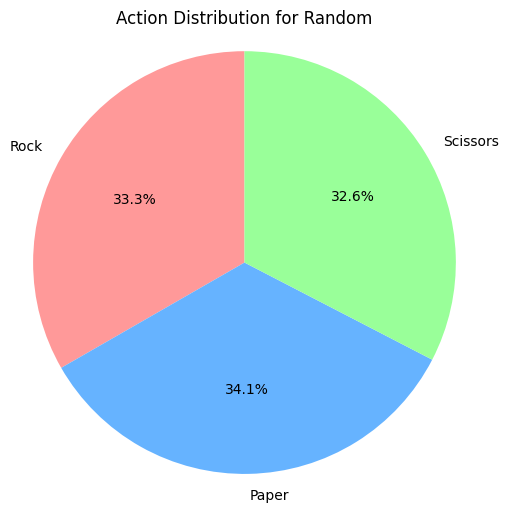


Analyzing strategy for match: FP_default_vs_IQL_default
FP_default action distribution: Rock=0.04, Paper=0.71, Scissors=0.25
IQL_default action distribution: Rock=0.00, Paper=0.51, Scissors=0.48


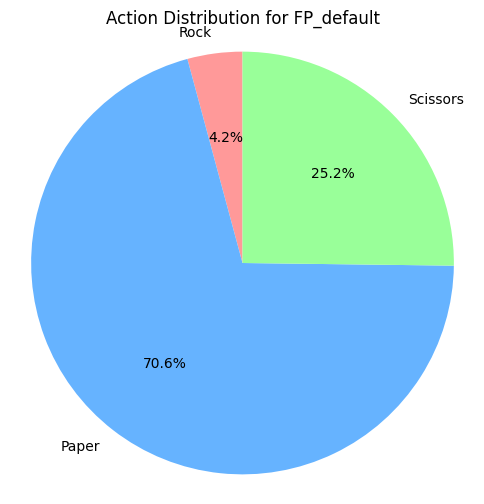

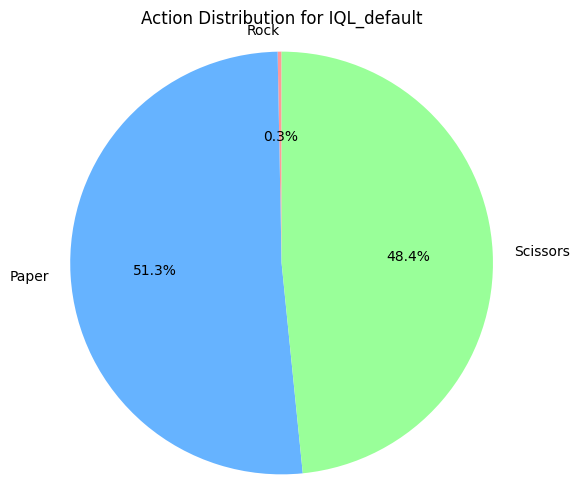


Analyzing strategy for match: RM_default_vs_JALAM_default
RM_default action distribution: Rock=0.34, Paper=0.33, Scissors=0.33
JALAM_default action distribution: Rock=0.34, Paper=0.34, Scissors=0.31


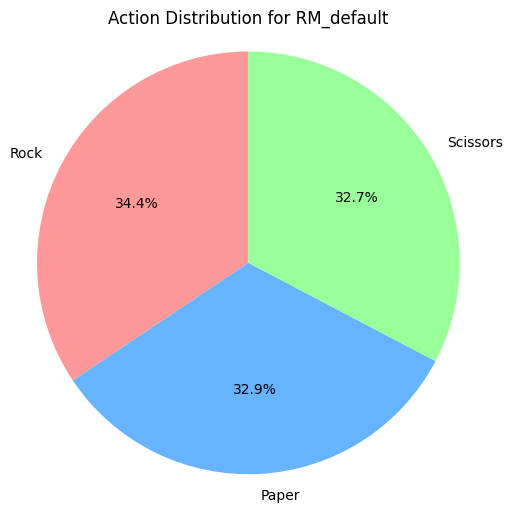

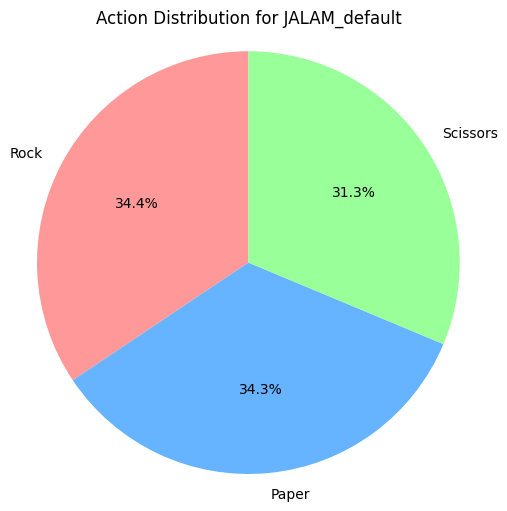


Conclusion: The strategy visualization shows how different agents approach the RPS game.
In a perfectly balanced strategy, each action would be chosen 1/3 of the time (33.3%).
Deviations from this balanced strategy indicate biases or learned patterns against specific opponents.


In [64]:
# 6. Strategy Analysis - Visualize action distributions
def plot_strategy(agent_name, action_dist, title=None):
    labels = ['Rock', 'Paper', 'Scissors']
    colors = ['#ff9999','#66b3ff','#99ff99']
    
    plt.figure(figsize=(6, 6))
    plt.pie(action_dist, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    if title:
        plt.title(title)
    else:
        plt.title(f'Action Distribution for {agent_name}')
    plt.show()

print("\n=== Strategy Analysis for Selected Matchups ===\n")

# Check if we have action distribution data
has_action_dist = False
for key, res in results.items():
    if 'action_dist_agent1' in res and 'action_dist_agent2' in res:
        has_action_dist = True
        break

if not has_action_dist:
    print("No action distribution data available. The run_match function might need to be updated to track actions.")
    print("See cell with function definition for adding action tracking.")
else:
    # Select some interesting matchups to analyze strategies
    interesting_matchups = [
        # Pick the best performing agent of each type against Random
        next((k for k in results.keys() if k.startswith('FP_') and 'Random' in k), None),
        next((k for k in results.keys() if k.startswith('RM_') and 'Random' in k), None),
        next((k for k in results.keys() if k.startswith('IQL_') and 'Random' in k), None),
        next((k for k in results.keys() if k.startswith('JALAM_') and 'Random' in k), None),
        # And some agent vs agent matchups
        next((k for k in results.keys() if k.startswith('FP_') and 'IQL_' in k), None),
        next((k for k in results.keys() if k.startswith('RM_') and 'JALAM_' in k), None),
    ]

    # Filter out None values (in case not all matchups exist)
    interesting_matchups = [m for m in interesting_matchups if m]

    # Plot strategy distributions for these matchups
    for match_key in interesting_matchups:
        if match_key in results:
            agent1_name, agent2_name = match_key.split('_vs_')
            print(f"\nAnalyzing strategy for match: {match_key}")
            
            res = results[match_key]
            if 'action_dist_agent1' in res and 'action_dist_agent2' in res:
                print(f"{agent1_name} action distribution: Rock={res['action_dist_agent1'][0]:.2f}, "
                    f"Paper={res['action_dist_agent1'][1]:.2f}, Scissors={res['action_dist_agent1'][2]:.2f}")
                print(f"{agent2_name} action distribution: Rock={res['action_dist_agent2'][0]:.2f}, "
                    f"Paper={res['action_dist_agent2'][1]:.2f}, Scissors={res['action_dist_agent2'][2]:.2f}")
                
                # Plot pie charts
                plot_strategy(agent1_name, res['action_dist_agent1'])
                plot_strategy(agent2_name, res['action_dist_agent2'])

    print("\nConclusion: The strategy visualization shows how different agents approach the RPS game.\n"
        "In a perfectly balanced strategy, each action would be chosen 1/3 of the time (33.3%).\n"
        "Deviations from this balanced strategy indicate biases or learned patterns against specific opponents.")

## Conclusión General

Analizando los resultados obtenidos:

- Los agentes de **Fictitious Play** tendieron a acercarse a una política casi uniforme, reflejando que sin un sesgo fuerte no logran ventaja sostenida.
- En **Regret Matching**, la versión sesgada (RM_biased) mostró un ligero aumento en la tasa de victoria contra agentes sin sesgo, aunque a costa de una mayor aparición de empatías.
- Entre los agentes de **Q-Learning Independiente**, la configuración _IQL_exploit_ obtuvo la mayor recompensa promedio y win rate, indicando que en un entorno de un solo paso es más efectivo priorizar la explotación una vez aprendidas las mejores acciones.
- El agente **JAL-AM** con configuración de exploración moderada (_JALAM_explore_) logró un equilibrio entre exploración y explotación, superando al agente aleatorio y aproximándose al desempeño de IQL.
- El **Agente Aleatorio** se mantuvo como referencia básica, con un rendimiento cercano a cero en recompensa promedio y 33.3% de victorias por azar.

En conjunto, estos resultados sugieren que para el juego RPS en un solo turno, las estrategias basadas en aprendizaje reforzado (IQL y JAL-AM) con hiperparámetros adecuados superan a los métodos basados en conteos o regret matching estático. Sin embargo, los métodos más simples siguen siendo valiosos como puntos de partida y control de referencia, ya que el completo azar fue el que mostro el mejor rendimiento en términos de victorias.